# Data Analysis for project Olist
GitHub location: https://github.com/LarsTinnefeld/olist_ecom_analysis.git

Questions to investigate:
- Are there correlations and patterns in the data which are important for the concept?
- What is the general business trend?
- How dynamic is the operation and are there extreme events which impact logistic process?
- What does the prediction say about the business in two years?

Structure of this notebook:
- Data import and preparation
- Exploratory data analysis
- Extracting trends and predictions from the order data
- Linear regression

---
# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
from datetime import datetime as dt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, classification_report
import sidetable
sns.set_style("whitegrid")

---
---
# Data import, checks and preparation
High level view of the content. Not all available data tables will be needed for the project, only:
- Order
- Order Items
- Prodcuts

In [2]:
df_orders = pd.read_csv("olist_orders_dataset.csv")
df_order_items = pd.read_csv("olist_order_items_dataset.csv")
df_products = pd.read_csv("olist_products_dataset.csv")

---
## Order data preparation
The order data table contains order IDs with time stamps and customer ID.

In [3]:
df_orders.describe().transpose()

,count,unique,top,freq
order_id,99441,99441,fcf62e3aab276898567e4ab7e973417f,1
customer_id,99441,99441,ba652878434f2ef707743bdf9444b46d,1
order_status,99441,8,delivered,96478
order_purchase_timestamp,99441,98875,2018-04-11 10:48:14,3
order_approved_at,99281,90733,2018-02-27 04:31:10,9
order_delivered_carrier_date,97658,81018,2018-05-09 15:48:00,47
order_delivered_customer_date,96476,95664,2017-12-02 00:26:45,3
order_estimated_delivery_date,99441,459,2017-12-20 00:00:00,522


In [4]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


2,965 missing delivery to customer dates (3%)

Date will need to be formated as datetime as well. The dates will be trimmed to date only (without time), so that they can be grouped by days later.

Important for our project are order purchase date, delivery date and estimated delivery date. I convert these two columns into datetime format and fill the mising values in column 'order_delivered_customer_date' with 'ffill'. Two items to take care of: 1) List must be in sorted order. 2) 'ffill' would not work for the first cells if they belong to the empty cells.

In [6]:
def convert_to_dt(dat, cols):
    '''Function takes in a dataframe name and date columns for conversion into datetime format'''
    for col in cols:
        dat[col] = pd.to_datetime(dat[col], format='%Y-%m-%d').dt.date

In [7]:
convert_to_dt(df_orders, ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
df_orders.sort_values(by = 'order_purchase_timestamp', inplace = True)

In [8]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
4541,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05,2016-10-07 13:17:15,NaN,NaT,2016-10-28
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13,2016-10-07 13:16:46,NaN,NaT,2016-09-30
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09,2016-10-04
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02,2016-10-06 15:50:56,NaN,NaT,2016-10-25


In [9]:
# First three 'order_delivered_customer_date' values are empty. These need to be deleted before 'ffill':
df_orders.drop(df_orders.index[:3], inplace = True)

In [10]:
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09,2016-10-04
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02,2016-10-06 15:50:56,NaN,NaT,2016-10-25
6747,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-14,2016-11-23


In [11]:
# Substitute missing date values:
df_orders['order_delivered_customer_date']\
    .fillna(method = 'ffill', inplace = True)
# check:
print('Missing values: ', df_orders['order_delivered_customer_date']\
    .isnull()\
    .sum())

Missing values:  0


In [12]:
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09,2016-10-04
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02,2016-10-06 15:50:56,NaN,2016-11-09,2016-10-25
6747,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-14,2016-11-23


Looks good. I will also add a column where the order date is expressed as ordinal format. This numerical format will simplify some of the processes later.

In [13]:
# Adding ordinal date column:
df_orders['date_ordinal'] = df_orders['order_purchase_timestamp']\
                            .apply(lambda date: date.toordinal())

When it comes to delivery time, these values can be of interest:
- Difference between estimated delivery date and true delivery date (shipping_time_delta)
- Difference between order date and delivery date (shipping_duration)
- Difference between order date and estimated delivery date (estimated_duration)

These columns will be created:

In [14]:
df_orders['shipping_time_delta'] = df_orders['order_estimated_delivery_date'] - df_orders['order_delivered_customer_date']
df_orders['shipping_duration'] = df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']
df_orders['estimated_duration'] = df_orders['order_estimated_delivery_date'] - df_orders['order_purchase_timestamp']

In [15]:
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date_ordinal,shipping_time_delta,shipping_duration,estimated_duration
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09,2016-10-04,736222,-36 days,55 days,19 days
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02,2016-10-06 15:50:56,NaN,2016-11-09,2016-10-25,736239,-15 days,38 days,23 days
6747,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-14,2016-11-23,736240,40 days,11 days,51 days


Checking if there are repeating orders:

In [16]:
print('Total of unique orders: {} \n\
Total of records: {}'
    .format(len(df_orders['order_id'].unique()), len(df_orders)))

Total of unique orders: 99438 
Total of records: 99438


The order data table looks good now.

----------
## Order_item data
The table contains the orders in detail with SKUs, seller and prices.

In [17]:
df_order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [18]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [19]:
df_order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [20]:
# Checking how many unique orders are listed
print('Total of unique orders in order_item table: {} \n\
Total of unique orders in order table: {} \n\
Total of records: {}'
    .format(
    len(df_order_items['order_id'].unique()),
    len(df_orders['order_id'].unique()),
    len(df_order_items))
    )


Total of unique orders in order_item table: 98666 
Total of unique orders in order table: 99438 
Total of records: 112650


The order table contains 775 order IDs more than in the order_items table (0.8%). This will be taken care of when merging or referencing the tables.

In [21]:
# Checking duplicate entries and duplicate order lines:
print('Number of duplcated records: {} \n\
Number of duplcated order lines: {}'
    .format(df_order_items.duplicated().sum(),
    df_order_items[['order_id', 'product_id']].duplicated().sum()))

Number of duplcated records: 0 
Number of duplcated order lines: 10225


This shows, that the structure of this order item table is not using order quantities but repeating order lines ('order_item_id' is a running order line count). In order to consolidate it in a form that allows to extract units-per-order line profile the table needs to be transformed. A new quantity column ('qty') will be added.

In [22]:
# Grouping by SKU and order ID:
df_order_items_consolidated = df_order_items\
    .groupby(by = ['product_id','order_id'])\
    .agg({
        'order_item_id': 'count', 
        'seller_id': 'first',
        'shipping_limit_date': 'first',
        'price': 'first',
        'freight_value': 'first'
        })\
    .reset_index()


In [23]:
# Checking is no info was lost
print('Orders in new table: {} \n\
Orders in old table: {} \n\
SKUs in new table: {} \n\
SKUs in old table: {} \n\
Total quantity in new table: {} \n\
Total quantity in old table: {}'
    .format(
    len(df_order_items_consolidated['order_id'].unique()),
    len(df_order_items['order_id'].unique()),
    len(df_order_items_consolidated['product_id'].unique()),
    len(df_order_items['product_id'].unique()),
    df_order_items_consolidated['order_item_id'].sum(),
    len(df_order_items)
    ))

Orders in new table: 98666 
Orders in old table: 98666 
SKUs in new table: 32951 
SKUs in old table: 32951 
Total quantity in new table: 112650 
Total quantity in old table: 112650


No data lost. The new quantity column needs to be renamed 'qty'.

In [24]:
# Renaming new quantity column
df_order_items_consolidated\
    .rename(columns = {'order_item_id': 'qty'}, inplace = True)

---
## Creating combined order table
To create a order-volume-time series we will merge the order and the order-items data tables.

Tables to combine:
- df_orders
- df_order_items_consolidated

Name of the combined table will remain 'df_order_items_consolidated'.

In [25]:
df_order_items_consolidated = df_orders\
    .merge(df_order_items_consolidated, on = 'order_id')

In [26]:
df_order_items_consolidated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102422 entries, 0 to 102421
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       102422 non-null  object         
 1   customer_id                    102422 non-null  object         
 2   order_status                   102422 non-null  object         
 3   order_purchase_timestamp       102422 non-null  object         
 4   order_approved_at              102408 non-null  object         
 5   order_delivered_carrier_date   101395 non-null  object         
 6   order_delivered_customer_date  102422 non-null  object         
 7   order_estimated_delivery_date  102422 non-null  object         
 8   date_ordinal                   102422 non-null  int64          
 9   shipping_time_delta            102422 non-null  timedelta64[ns]
 10  shipping_duration              102422 non-null  timedelt

In [27]:
df_order_items_consolidated.describe()

,date_ordinal,shipping_time_delta,shipping_duration,estimated_duration,qty,price,freight_value
count,102422.000000,102422,102422,102422,102422.000000,102422.000000,102422.000000
mean,736694.315606,12 days 00:13:40.792407,12 days 10:36:22.452988,24 days 10:50:03.245396,1.099832,124.424358,20.110971
std,153.412797,10 days 07:29:21.243933,9 days 12:47:45.151492,8 days 20:20:41.856412,0.456933,188.928341,15.884844
min,736222.000000,-188 days +00:00:00,-4 days +00:00:00,3 days 00:00:00,1.000000,0.850000,0.000000
25%,736585.000000,7 days 00:00:00,7 days 00:00:00,19 days 00:00:00,1.000000,40.000000,13.140000
50%,736713.000000,13 days 00:00:00,10 days 00:00:00,24 days 00:00:00,1.000000,78.800000,16.320000
75%,736818.000000,17 days 00:00:00,16 days 00:00:00,29 days 00:00:00,1.000000,139.000000,21.220000
max,736940.000000,147 days 00:00:00,210 days 00:00:00,156 days 00:00:00,20.000000,6735.000000,409.680000


In [28]:
df_order_items_consolidated.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date_ordinal,shipping_time_delta,shipping_duration,estimated_duration,product_id,qty,seller_id,shipping_limit_date,price,freight_value
0,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09,2016-10-04,736222,-36 days,55 days,19 days,5a6b04657a4c5ee34285d1e4619a96b4,3,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
1,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02,2016-10-06 15:50:56,NaN,2016-11-09,2016-10-25,736239,-15 days,38 days,23 days,d2998d7ced12f83f9b832f33cf6507b6,1,25e6ffe976bd75618accfe16cefcbd0d,2016-10-21 16:19:54,100.00,9.34
2,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-14,2016-11-23,736240,40 days,11 days,51 days,e2a1d45a73dc7f5a7f9236b043431b89,1,b499c00f28f4b7069ff6550af8c1348a,2016-10-08 10:34:01,29.99,10.96


The merge process was done in a way that the orders which were only existing in one table were dropped. Confirming:

In [29]:
print('Total of unique orders in consolidated order table: {} \n\
Total of unique orders in order table: {}'
    .format(
    len(df_order_items_consolidated['order_id'].unique()),
    len(df_orders['order_id'].unique())
    ))

Total of unique orders in consolidated order table: 98664 
Total of unique orders in order table: 99438


The combined order table is ready.

---
## Products table preparation
The products lookup table contains details about the ordered products, their description and physical properties. Physical properties are one side of the filter process to review the business case from a technological angle of view.

In [30]:
df_products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [31]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [32]:
df_products.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


Checking if duplicate records exist:

In [33]:
df_products['product_id'].duplicated().sum()

0

This looks good. Checking if all ordered items are contained in the product table:

In [34]:
print('SKU count in order table: {} \n\
SKU count in product table: {}'
    .format(
    len(df_order_items_consolidated['product_id'].unique()),
    len(df_products['product_id'].unique())
    ))
df_products['product_id'].equals(df_order_items_consolidated['product_id'])

SKU count in order table: 32949 
SKU count in product table: 32951


False

The number of unique SKUs in both tables almost matches (2 differnt) which would look OK, but apparently there are SKUs which don't match. The tables will be merged and the counts of the non-null columns will reveal how many SKUs will have no SKU details. We continue to stick with 'df_order_items_consolidated' as our consolidated table.

---
## Merging product table to consolidated order table 

In [35]:
df_order_items_consolidated = df_order_items_consolidated\
    .merge(df_products, on = 'product_id')

In [36]:
df_order_items_consolidated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102422 entries, 0 to 102421
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       102422 non-null  object         
 1   customer_id                    102422 non-null  object         
 2   order_status                   102422 non-null  object         
 3   order_purchase_timestamp       102422 non-null  object         
 4   order_approved_at              102408 non-null  object         
 5   order_delivered_carrier_date   101395 non-null  object         
 6   order_delivered_customer_date  102422 non-null  object         
 7   order_estimated_delivery_date  102422 non-null  object         
 8   date_ordinal                   102422 non-null  int64          
 9   shipping_time_delta            102422 non-null  timedelta64[ns]
 10  shipping_duration              102422 non-null  timedelt

16 SKUs (0.05%) have not dimension information, which is negligible. We will substitute these missing information with the averages.

In [37]:
# Filling in average values for missing product values
def subst_mean(dat, cols):
    '''Function takes in name of a data frame and list of columns to substitute, na cells will be filled with mean'''
    for col in cols:
        dat[col] = dat[col].fillna(dat[col].mean())

In [38]:
subst_mean(df_order_items_consolidated, [
    'product_length_cm',
    'product_weight_g',
    'product_height_cm',
    'product_width_cm'
    ])

In [39]:
df_order_items_consolidated.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date_ordinal,102422,736694,153.413,736222,736585,736713,736818,736940
shipping_time_delta,102422,12 days 00:13:40.792407,10 days 07:29:21.243933,-188 days +00:00:00,7 days 00:00:00,13 days 00:00:00,17 days 00:00:00,147 days 00:00:00
shipping_duration,102422,12 days 10:36:22.452988,9 days 12:47:45.151492,-4 days +00:00:00,7 days 00:00:00,10 days 00:00:00,16 days 00:00:00,210 days 00:00:00
estimated_duration,102422,24 days 10:50:03.245396,8 days 20:20:41.856412,3 days 00:00:00,19 days 00:00:00,24 days 00:00:00,29 days 00:00:00,156 days 00:00:00
qty,102422,1.09983,0.456933,1,1,1,1,20
price,102422,124.424,188.928,0.85,40,78.8,139,6735
freight_value,102422,20.111,15.8848,0,13.14,16.32,21.22,409.68
product_name_lenght,100962,48.8749,9.99746,5,43,52,57,76
product_description_lenght,100962,787.272,650.594,4,348,603,987,3992
product_photos_qty,100962,2.23992,1.74343,1,1,2,3,20


Looks good. We will add an additional column 'cube' to have the shipped volume information on hand.

In [40]:
df_order_items_consolidated['order_line_cube_in_ltr']\
    = df_order_items_consolidated['product_length_cm']\
    *df_order_items_consolidated['product_height_cm']\
    *df_order_items_consolidated['product_width_cm']\
    /1000*df_order_items_consolidated['qty']

In [41]:
df_order_items_consolidated.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date_ordinal,shipping_time_delta,...,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_line_cube_in_ltr
0,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09,2016-10-04,736222,-36 days,...,2.83,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,12.288
1,38c5c2886f2aab75bb1ae3f79a3f300d,6676a459c2b773481c9dacde3c44c680,delivered,2016-10-08,2016-10-08 09:10:46,2016-10-12 09:10:47,2016-10-26,2016-11-30,736245,35 days,...,9.49,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,4.096
2,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02,2016-10-06 15:50:56,NaN,2016-11-09,2016-10-25,736239,-15 days,...,9.34,bebes,32.0,561.0,1.0,500.0,18.0,18.0,18.0,5.832


This completes the preparation of a consolidated order table.

---
## Creating a daily order summary table

In [42]:
df_order_items_consolidated.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'date_ordinal', 'shipping_time_delta', 'shipping_duration',
       'estimated_duration', 'product_id', 'qty', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_line_cube_in_ltr'],
      dtype='object')

In [43]:
# Grouping by days: Panadas has a challenge to apply aggregat functions to timedelta fomats ('shipping_duration' and 'shipping_time_delta'). 3 steps: Converting to int64, aggregate, converting back to timedelta format. Step 1 (converting to int64):
def datetime_to_int(dat, cols):
    '''Function takes in name of a data frame and list of columns to convert cells will be converted from datetime to int64'''
    for col in cols:
        dat[col] = dat[col].values.astype(np.int64)

In [44]:
datetime_to_int(df_order_items_consolidated, [
    'shipping_duration',
    'shipping_time_delta',
    'estimated_duration'
    ])

In [45]:
# Step 2: Groupby and apllying aggregat functions for daily summaries:
df_orders_daily\
    =df_order_items_consolidated\
    .groupby('order_purchase_timestamp')\
    .agg({
        'date_ordinal': 'first',
        'qty':'sum',
        'order_id':'count',
        'order_line_cube_in_ltr': 'sum',
        'freight_value': 'sum',
        'price':'sum',
        'shipping_duration': 'mean',
        'shipping_time_delta': 'mean',
        'estimated_duration': 'mean'
        }).reset_index()

In [46]:
# Step 3: Converting back to timedelta:
def int_to_datetime(dat, cols):
    '''Function takes in name of a data frame and list of columns to convert cells will be converted from int to datetime'''
    for col in cols:
        dat[col] = pd.to_timedelta(dat[col], 'ns').dt.days

In [47]:
int_to_datetime(df_order_items_consolidated, [
    'shipping_duration',
    'shipping_time_delta',
    'estimated_duration'
    ])
int_to_datetime(df_orders_daily, [
    'shipping_duration',
    'shipping_time_delta',
    'estimated_duration'
])

Adding orders-per-day and SKUs-per-day

In [48]:
df_orders_consolidated\
    = df_order_items_consolidated\
    .groupby(['order_purchase_timestamp', 'order_id'])\
    .agg({'customer_id': 'count'}).reset_index()
df_orders_consolidated\
    = df_orders_consolidated\
    .groupby('order_purchase_timestamp')\
    .agg({'order_id':'count'})\
    .sort_values('order_purchase_timestamp')
df_orders_consolidated\
    .rename(columns={'order_id': 'orders_count'}, inplace = True)

In [49]:
df_SKUs_consolidated\
    = df_order_items_consolidated\
    .groupby(['order_purchase_timestamp', 'product_id'])\
    .agg({'customer_id': 'count'}).reset_index()
df_SKUs_consolidated\
    = df_SKUs_consolidated\
    .groupby('order_purchase_timestamp')\
    .agg({'product_id':'count'})\
    .sort_values('order_purchase_timestamp')
df_SKUs_consolidated\
    .rename(columns={'product_id': 'SKU_count'}, inplace = True)

In [50]:
df_orders_daily\
    = df_orders_daily\
    .merge(df_orders_consolidated, on = 'order_purchase_timestamp')
df_orders_daily\
    = df_orders_daily\
    .merge(df_SKUs_consolidated, on = 'order_purchase_timestamp')

In [51]:
df_orders_daily.rename(columns={
    'order_id': 'order_lines',
    'order_line_cube_in_ltr': 'total_cube',
    'price': 'turnover',
    'shipping_duration': 'avg_shipping_duration',
    'shipping_time_delta': 'avg_shipping_time_delta',
    'estimated_duration': 'avg_estimated_duration'
    }, inplace=True)

In [52]:
df_orders_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_purchase_timestamp  614 non-null    object 
 1   date_ordinal              614 non-null    int64  
 2   qty                       614 non-null    int64  
 3   order_lines               614 non-null    int64  
 4   total_cube                614 non-null    float64
 5   freight_value             614 non-null    float64
 6   turnover                  614 non-null    float64
 7   avg_shipping_duration     614 non-null    int64  
 8   avg_shipping_time_delta   614 non-null    int64  
 9   avg_estimated_duration    614 non-null    int64  
 10  orders_count              614 non-null    int64  
 11  SKU_count                 614 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 62.4+ KB


---
---
# Exploratory data analysis
## Are there correlations and patterns in the data which are important for the concept?

### Following tables are available after the data preparation step:
- df_order_items_consolidated
- df_order_daily

still available:
- df_orders
- df_order_items
- df_products

### Points of interest:
- Patterns or correlations in the data
- Distributions and unusual characteristics
- Observations that lead to more detailed investigations for the business evaluation

---
## Order data
### Checking order price distribution:

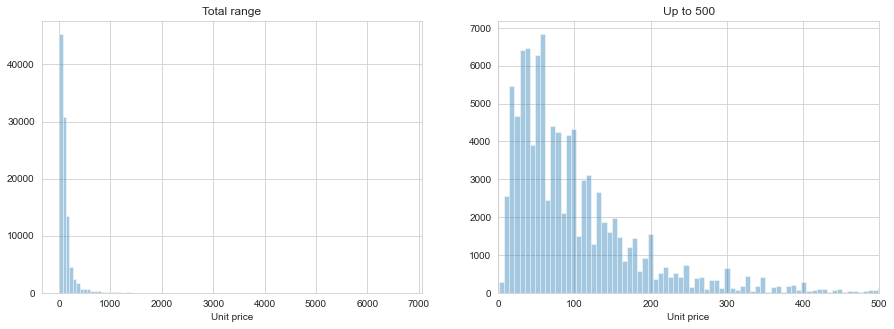

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.set_title('Total range')
ax2.set_title('Up to 500')

ax2.set_xlim([0, 500])

sns.distplot(df_order_items_consolidated['price'],
            bins = 100,
            ax = ax1,
            axlabel = 'Unit price',
            kde = False)
sns.distplot(df_order_items_consolidated['price'],
            bins = 1000,
            ax = ax2,
            axlabel = 'Unit price',
            kde = False);

No currency was provided with the data set, but I assume this Brazilian Real. The statistical mean for the item price is 120, but this based on a skewed distribution. The majority of the prices is in the lower range of up to 100.

Checking the distribution of the oder status:

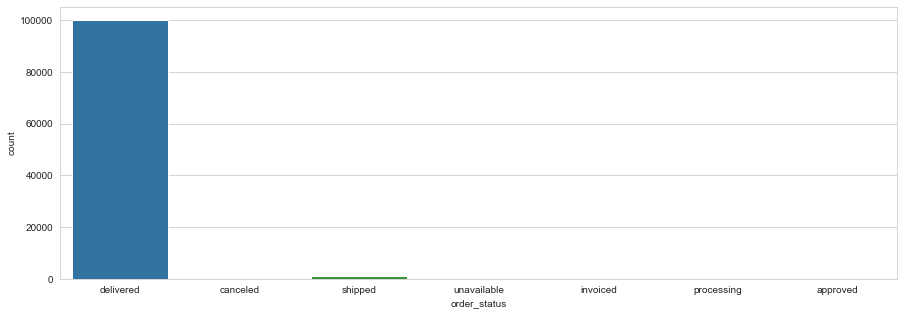

In [54]:
# Visualizing the distribution of the delivery status
plt.figure(figsize = (15, 5))
sns.countplot(df_order_items_consolidated['order_status']);

In [55]:
df_order_items_consolidated.stb.freq(['order_status'])

,order_status,count,percent,cumulative_count,cumulative_percent
0,delivered,100196,97.826639,100196,97.826639
1,shipped,1125,1.098397,101321,98.925036
2,canceled,464,0.453028,101785,99.378063
3,invoiced,322,0.314386,102107,99.692449
4,processing,306,0.298764,102413,99.991213
5,unavailable,7,0.006834,102420,99.998047
6,approved,2,0.001953,102422,100.000000


Almost 100% of the orders are flagged as delivered. It's unlikely that this will give too much insights.

Checking general correlations:

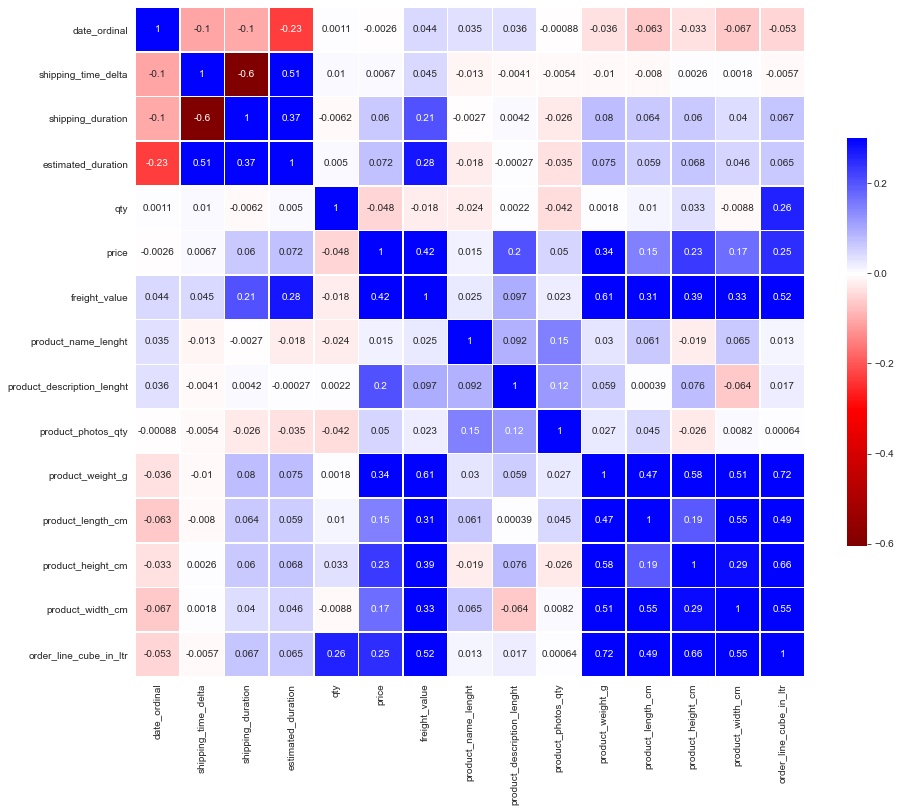

In [56]:
plt.figure(figsize = (15, 15))
sns.heatmap(df_order_items_consolidated.corr(),
            cmap = 'seismic_r',
            vmax = 0.3, center=0,
            square = True,
            linewidths = 0.5,
            cbar_kws = {"shrink": 0.5},
            annot = True);

Dependencies between dimension and weight is no surprise. We can also see that the freight price is correlated to the product weight.

It would now be interesting to see if the shipping duration, its estimation and the timeliness of the shipments is correlated to the freight value. The map shows a rather low correlation.

In [57]:
# Trying linear regression
X = df_order_items_consolidated[['shipping_duration', 'estimated_duration']]
y = df_order_items_consolidated['freight_value']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
# Setting up linear regresion model
# We don't need to normalize in this case, because we have only one input feature
lm_model = LinearRegression()
# Fit the data to the model. Because we have only one x-feature in a form of a 
# 1Xm vector, we need to reshape it to mX1 before fitting it to the model
lm_model.fit(X_train, y_train)
# Generating predictions
y_preditions_train = lm_model.predict(X_train)
y_preditions_test = lm_model.predict(X_test)
# Validating the precision of the model with the r2-score
print(r2_score(y_train, y_preditions_train))
print(r2_score(y_test, y_preditions_test))

0.08804263389286615
0.09144802522026985


This looks like a rather low linear dependency. Let's check if the range of shipping durancions has some link to product price.

In [59]:
# Binning of product prices
df_order_items_consolidated['price_round']\
    = round(df_order_items_consolidated['price']/10)*10

In [60]:
df_ship_price_test\
    = df_order_items_consolidated\
    .groupby('price_round')\
    .agg({
        'shipping_duration': ['max', 'min'],
        'estimated_duration': ['max', 'min']
        })\
    .reset_index()\
    .sort_values('price_round')

In [61]:
df_ship_price_test['true_ship_range']\
    = df_ship_price_test.shipping_duration['max']\
    - df_ship_price_test.shipping_duration['min']
df_ship_price_test['estimated_ship_range']\
    = df_ship_price_test.estimated_duration['max']\
    - df_ship_price_test.estimated_duration['min']

In [62]:
df_ship_price_test

price_round shipping_duration     estimated_duration     true_ship_range  \
                              max min                max min                   
0           0.0                64   2                 46   7              62   
1          10.0               101   1                 59   3             100   
2          20.0               175   1                 68   3             174   
3          30.0               188   1                147   3             187   
4          40.0               190   1                117   3             189   
..          ...               ...  ..                ...  ..             ...   
237      4690.0                19  19                 27  27               0   
238      4800.0                16  16                 31  31               0   
239      6500.0                12  12                 35  35               0   
240      6730.0                21  21                 16  16               0   
241      6740.0                19  19                 25  25               0   

    estimated_ship_range  
                          
0                     39  
1                     56  
2                     65  
3                    144  
4                    114  
..                   ...  
237                    0  
238                    0  
239                    0  
240                    0  
241                    0  

[242 rows x 7 columns]

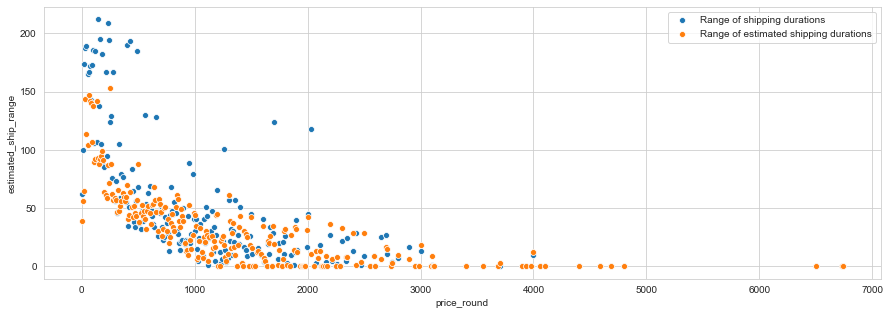

In [63]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data = df_ship_price_test,
                y = 'true_ship_range',
                x = 'price_round')
sns.scatterplot(data = df_ship_price_test,
                y = 'estimated_ship_range',
                x = 'price_round')
plt.legend([
            'Range of shipping durations',
            'Range of estimated shipping durations'
            ]);

## Theses scatterplots are temporarily deactivated because they increase the file size.

In [64]:
#plt.figure(figsize=(15, 5))
#sns.scatterplot(data = df_order_items_consolidated, x = 'price', y = 'shipping_duration')
#plt.xlabel('Product Price')
#plt.ylabel('Shipping duration');

In [65]:
#plt.figure(figsize=(15, 5))
#sns.scatterplot(data = df_order_items_consolidated, x = 'price', y = 'estimated_duration')
#plt.xlabel('Product Price')
#plt.ylabel('Estimated duration');

In [66]:
#plt.figure(figsize=(15, 5))
#sns.scatterplot(data = df_order_items_consolidated, x = 'price', y = 'shipping_time_delta')
#plt.xlabel('Product Price')
#plt.ylabel('Planned vs. true delivery duration');

### Reviewing product categories

20 Most sold product categories:

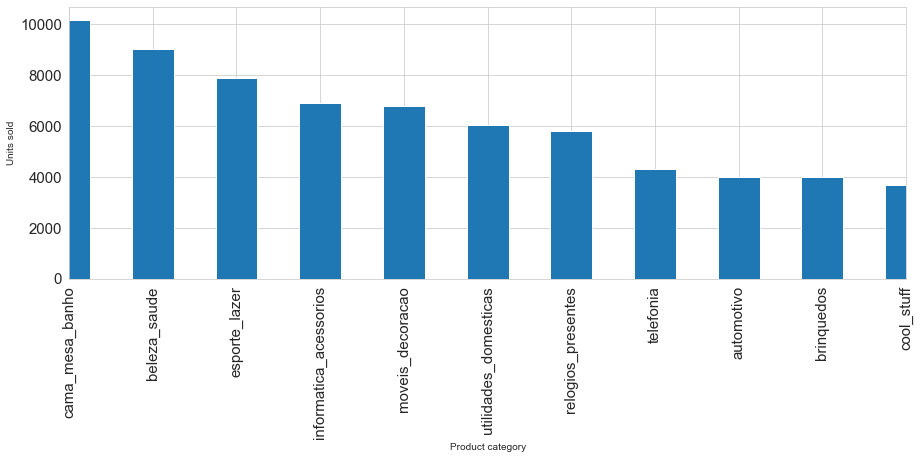

In [67]:
plt.xlabel('Product category')
plt.ylabel('Units sold')
df_order_items_consolidated['product_category_name']\
    .value_counts()\
    .plot(kind = "bar", fontsize = 15, figsize = (15, 5))
plt.xlim(0, 10);

In [68]:
df_order_items_consolidated['product_category_name'].value_counts().head(20)

cama_mesa_banho                10160
beleza_saude                    9022
esporte_lazer                   7858
informatica_acessorios          6887
moveis_decoracao                6779
utilidades_domesticas           6019
relogios_presentes              5799
telefonia                       4286
automotivo                      3991
brinquedos                      3979
cool_stuff                      3658
ferramentas_jardim              3607
perfumaria                      3242
bebes                           2933
eletronicos                     2565
papelaria                       2381
fashion_bolsas_e_acessorios     1979
pet_shop                        1772
moveis_escritorio               1303
consoles_games                  1080
Name: product_category_name, dtype: int64

In [69]:
df_order_items_consolidated['product_category_name'].count()

100962

20 product caregories with hightest turnover:

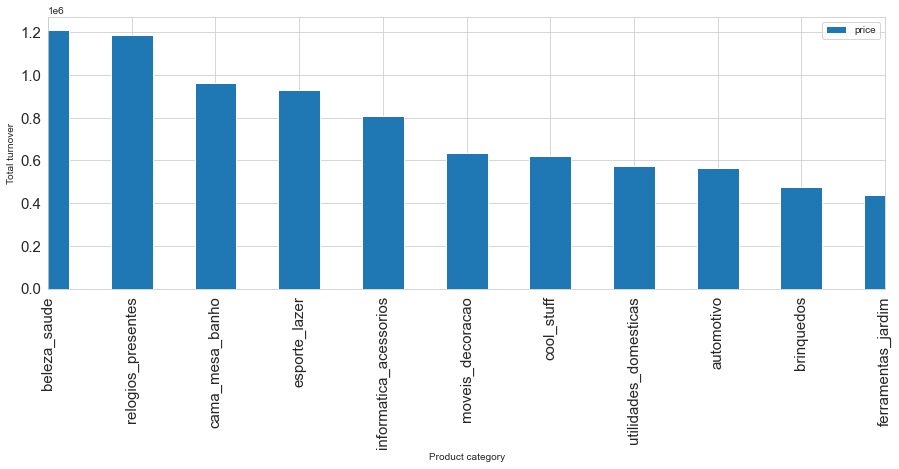

In [70]:
df_order_items_consolidated\
    .groupby('product_category_name')\
    .agg({'price': 'sum'})\
    .sort_values(by = 'price', ascending = False)\
    .plot(kind = "bar", fontsize = 15, figsize = (15, 5))
plt.xlabel('Product category')
plt.ylabel('Total turnover')
plt.xlim(0, 10);

In [71]:
df_order_items_consolidated\
    .groupby('product_category_name')\
    .agg({'price': 'sum'})\
    .sort_values(by = 'price', ascending = False)\
    .head(20)

,price
product_category_name,
beleza_saude,1212149.92
relogios_presentes,1187533.96
cama_mesa_banho,963519.89
esporte_lazer,929271.47
informatica_acessorios,806515.13
moveis_decoracao,632971.03
cool_stuff,621631.74
utilidades_domesticas,573847.89
automotivo,563780.16


In [72]:
df_order_items_consolidated['price'].sum()

12743791.610000001

Product categories with the most SKUs:

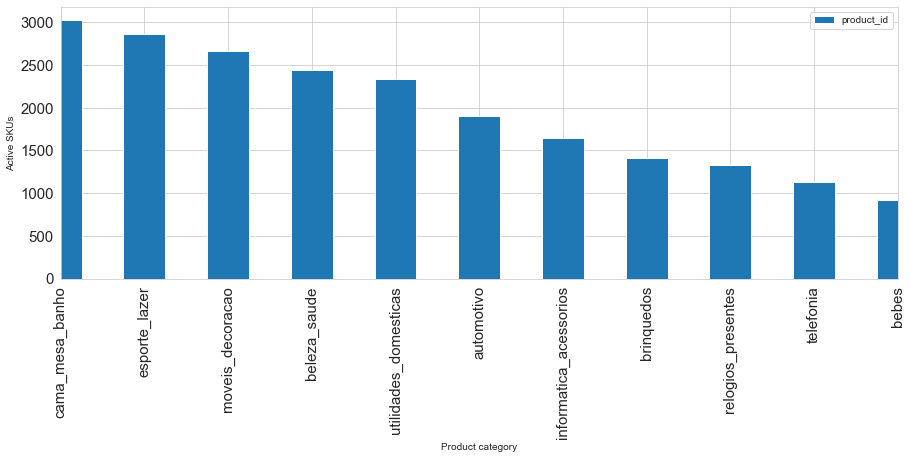

In [73]:
df_products\
    .groupby('product_category_name')\
    .agg({'product_id': 'count'})\
    .sort_values(by = 'product_id', ascending = False)\
    .plot(kind = "bar", fontsize = 15, figsize = (15, 5))
plt.xlabel('Product category')
plt.ylabel('Active SKUs')
plt.xlim(0, 10);

In [74]:
df_products['product_category_name'].value_counts().head(20)

cama_mesa_banho                      3029
esporte_lazer                        2867
moveis_decoracao                     2657
beleza_saude                         2444
utilidades_domesticas                2335
automotivo                           1900
informatica_acessorios               1639
brinquedos                           1411
relogios_presentes                   1329
telefonia                            1134
bebes                                 919
perfumaria                            868
fashion_bolsas_e_acessorios           849
papelaria                             849
cool_stuff                            789
ferramentas_jardim                    753
pet_shop                              719
eletronicos                           517
construcao_ferramentas_construcao     400
eletrodomesticos                      370
Name: product_category_name, dtype: int64

### Exploratory analysis conclusions

1) The top 10 product categories are (s. also bar charts):
- cama_mesa_banho
- esporte_lazer
- moveis_decoracao
- beleza_saude
- utilidades_domesticas
- automotivo
- informatica_acessorios
- brinquedos
- relogios_presentes
- telefonia
- bebes

2) Categories of special interest: beleza_saude, relogios_presentes

3) Procut categories mostly in the lower range of up to 100 Real, some outliers exceed to 7000 Real

4) Delivery time for expensive product has potentially lower variance

---
---
## Time series analysis

### Purpose
- Finding trends over time that allows predictions for the future
- Visualizing if there are repeating patterns (seasonality or other)
- Exploring unusual observations and how predictable the data are

In [75]:
df_orders_daily

,order_purchase_timestamp,date_ordinal,qty,order_lines,total_cube,freight_value,turnover,avg_shipping_duration,avg_shipping_time_delta,avg_estimated_duration,orders_count,SKU_count
0,2016-09-15,736222,3,1,12.288,2.83,44.99,55,-36,19,1,1
1,2016-10-02,736239,1,1,5.832,9.34,100.00,38,-15,23,1,1
2,2016-10-03,736240,8,8,100.844,131.66,463.48,26,21,47,8,8
3,2016-10-04,736241,69,65,1277.503,1276.84,9642.36,25,31,56,60,57
4,2016-10-05,736242,56,47,1292.398,1098.68,7464.15,20,35,56,42,45
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2018-08-26,736932,82,78,824.053,1202.44,7745.92,3,9,12,73,74
610,2018-08-27,736933,71,67,769.109,729.68,5227.92,2,5,7,66,67
611,2018-08-28,736934,45,40,557.697,400.07,3427.32,1,6,8,39,40
612,2018-08-29,736935,16,11,295.701,138.58,970.84,1,6,7,11,11


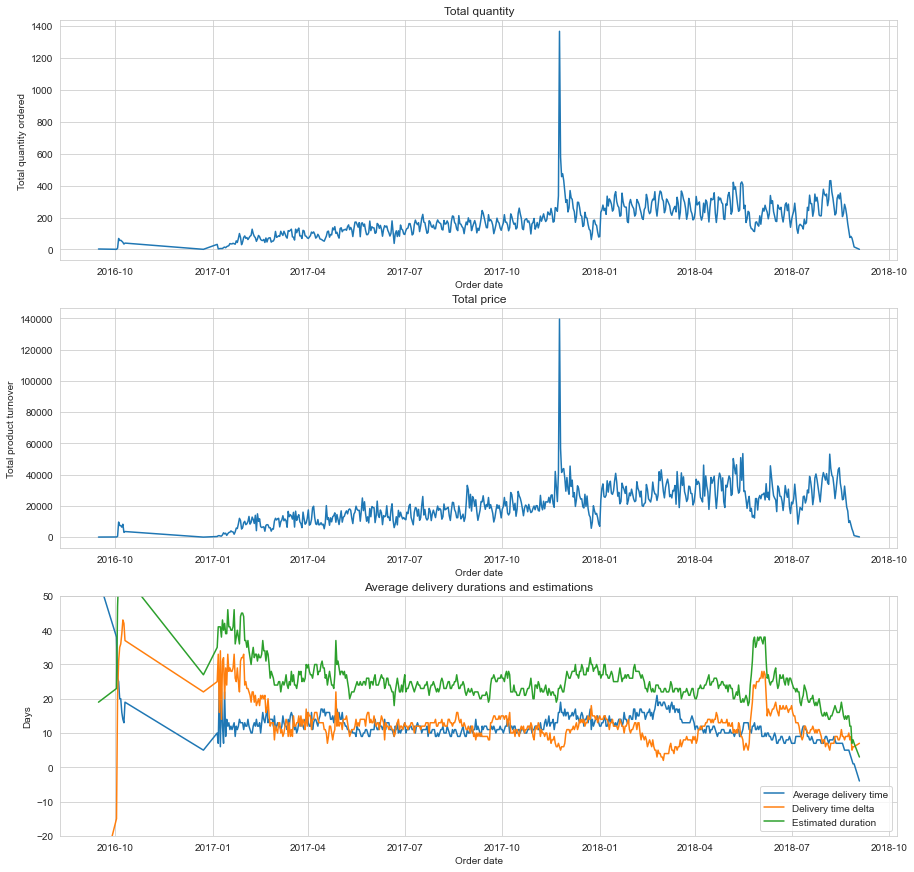

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 15))
ax1.set_title('Total quantity')
ax2.set_title('Total price')
ax3.set_title('Average delivery durations and estimations')

sns.lineplot(
            data = df_orders_daily,
            x = 'order_purchase_timestamp',
            y ='qty',
            ax = ax1
            )

sns.lineplot(
            data = df_orders_daily,
            x = 'order_purchase_timestamp',
            y = 'turnover',
            ax = ax2
            )

sns.lineplot(
            data = df_orders_daily,
            x = 'order_purchase_timestamp',
            y = 'avg_shipping_duration',
            ax = ax3
            )
sns.lineplot(
            data = df_orders_daily,
            x = 'order_purchase_timestamp',
            y = 'avg_shipping_time_delta',
            ax = ax3
            )
sns.lineplot(
            data = df_orders_daily,
            x = 'order_purchase_timestamp',
            y = 'avg_estimated_duration',
            ax = ax3
            )

ax1.set(xlabel = 'Order date', ylabel = 'Total quantity ordered')
ax2.set(xlabel = 'Order date', ylabel = 'Total product turnover')
ax3.set(xlabel = 'Order date', ylabel = 'Days', ylim = (-20, 50))
ax3.legend([
            'Average delivery time',
            'Delivery time delta',
            'Estimated duration'
            ]);

In [77]:
# Finding the location of the spike
df_orders_daily[df_orders_daily['qty'] == df_orders_daily['qty'].max()]

,order_purchase_timestamp,date_ordinal,qty,order_lines,total_cube,freight_value,turnover,avg_shipping_duration,avg_shipping_time_delta,avg_estimated_duration,orders_count,SKU_count
334,2017-11-24,736657,1366,1231,19515.468,23465.16,139471.97,16,6,23,1166,919


The upper three time series charts above show the daily summarized total units and order lines shipped and tunover. The time chart below that shows average delivery duration, estimated delivery duration and time delta between estimated date and true date (positive values indicate that the shippment arrived earlier than predicted).

The general trend shows an increase in the order volume. There is a heavy peak at Black Friday. The spike can be expected for an e-commerce business, but the magnitude is concerning when it comes to projections in logistic- and warehouse concept development.

During Black Friday the average shipping duration went up and the time estimation had less buffer.

There is a sudden steep uptick in the estimated shippment estimation mid to end of June 2018. This falls in the time period of the FIFA World Cup. Because shipping durations did not go up in this time the sipping duration was overestimated (more safety was included).

In [78]:
df_orders_daily[[
                'qty',
                'order_lines',
                'orders_count',
                'SKU_count',
                'total_cube',
                'turnover'
                ]].describe()

,qty,order_lines,orders_count,SKU_count,total_cube,turnover
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,183.464169,166.811075,160.690554,154.052117,2796.616011,20755.360928
std,105.551768,94.903867,91.091829,81.499210,1504.732555,11667.468753
min,1.000000,1.000000,1.000000,1.000000,0.352000,10.900000
25%,113.250000,103.000000,99.000000,98.000000,1869.491500,12501.375000
50%,169.000000,154.000000,148.500000,145.000000,2711.480500,19430.730000
75%,245.750000,223.000000,215.750000,208.000000,3628.311250,27427.047500
max,1366.000000,1231.000000,1166.000000,919.000000,19515.468000,139471.970000


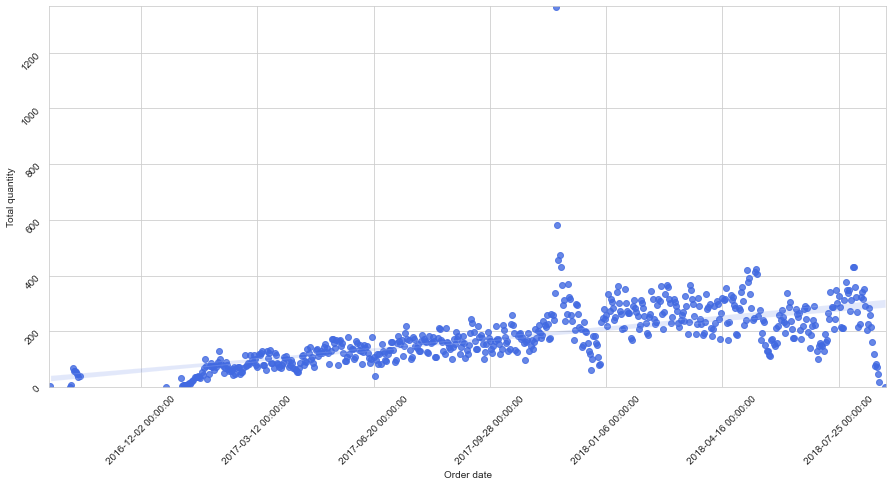

In [79]:
plt.figure(figsize=(15, 7))
ax = sns.regplot(
                data = df_orders_daily,
                x = 'date_ordinal',
                y = 'qty',
                color = 'royalblue')

ax.set_xlim(df_orders_daily['date_ordinal'].min()
            - 1, df_orders_daily['date_ordinal'].max()
            + 1)
ax.set_ylim(0, df_orders_daily['qty'].max() + 1)

ax.set_xlabel('Order date')
ax.set_ylabel('Total quantity')
new_labels = [dt.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
ax.tick_params(labelrotation=45)

There is a clear upward trend in the business which can be seen in turnover and order volume.
Alsough the spike at Black Friday is typical for e-commerce businesses, the enormeous magnitude is a concern which needs to be addressed in the review of the logistic process.

### Linear regression

Splitting the data into target feature (for simplicity we select quantity,
but the process could be repeated for turnover and order lines) and the timeline.
Normally, all remaining numerical features would represent the input values,
but in this case all these values are linked and dependent on each other
(more qty means more turnover and more order lines).

In [80]:
# Separating features and results
X = pd.to_datetime(df_orders_daily['order_purchase_timestamp'])
y = np.array(df_orders_daily['qty'])
# Splitting into train- and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
# Setting up linear regresion model
# We don't need to normalize in this case, because we have only one input feature
lm_model = LinearRegression()
# Fit the data to the model. Because we have only one x-feature in a form of a 
# 1Xm vector, we need to reshape it to mX1 before fitting it to the model
lm_model.fit(X_train.values.reshape(-1, 1), y_train.reshape(-1, 1))
# Generating predictions
y_preditions_train = lm_model.predict(X_train.values.astype(float).reshape(-1, 1))
y_preditions_test = lm_model.predict(X_test.values.astype(float).reshape(-1, 1))
# Validating the precision of the model with the r2-score
print(r2_score(y_train, y_preditions_train))
print(r2_score(y_test, y_preditions_test))

0.364322793074514
0.5274936118253968


This looks like a pretty bad working model. Potentially, the data points have a too high variation which makes predictions uncertain. I tried with different training sized with the same outcome. That means the sizing of a potential future logistic process need to have enough flexibility to handle this variance.

Let's try a data set wich has the days with extreme outliers. The drop of data at the end of the dataset could potentially be incomplete data (because the orders have not been delivered/ completed?). The tailend after 2018-08-16 will be removed from the data set. For the system sizing of a hypothetical warehouse system this would mean we need to describe a peak day scenario separately.

In [81]:
df_orders_no_peaks = df_orders_daily.iloc[14:-14]
df_orders_no_peaks\
    .drop(df_orders_no_peaks[df_orders_no_peaks.qty > 400]\
    .index, inplace=True)

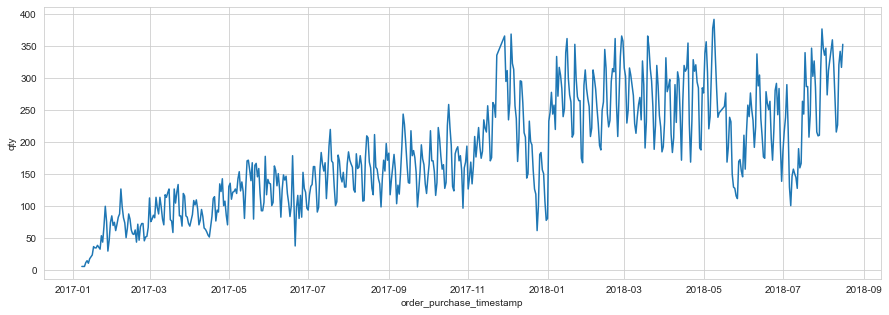

In [82]:
plt.figure(figsize = (15, 5))
sns.lineplot(
            data = df_orders_no_peaks,
            x = 'order_purchase_timestamp',
            y = 'qty'
            );

Setting up the linear regression model with this data:

In [83]:
X = pd.to_datetime(df_orders_no_peaks['order_purchase_timestamp'])
y = np.array(df_orders_no_peaks['qty'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
lm_model = LinearRegression()
lm_model.fit(X_train.values.reshape(-1, 1), y_train.reshape(-1, 1))
y_preditions_train = lm_model.predict(X_train.values.astype(float).reshape(-1, 1))
y_preditions_test = lm_model.predict(X_test.values.astype(float).reshape(-1, 1))
print(r2_score(y_train, y_preditions_train))
print(r2_score(y_test, y_preditions_test))

0.5710155412961145
0.6635065110490217


This looks slightly better. This model predicts in the range of 55-65% accuracy. Let's visualize this model and extend the prognosis to 2020.

In [84]:
# Generating dummy data set for prediction timeframe
pred_dates = pd.Series(pd.date_range(
                        start='2017-01-01',
                        end = '2020-01-01',
                        freq='d'
                        ))
df_pred = pd.DataFrame({'date': pred_dates})
df_pred['reg_line']\
    = lm_model.predict(pred_dates.values.astype(float).reshape(-1, 1))
df_pred.head()

,date,reg_line
0,2017-01-01,66.137761
1,2017-01-02,66.525818
2,2017-01-03,66.913875
3,2017-01-04,67.301932
4,2017-01-05,67.689989


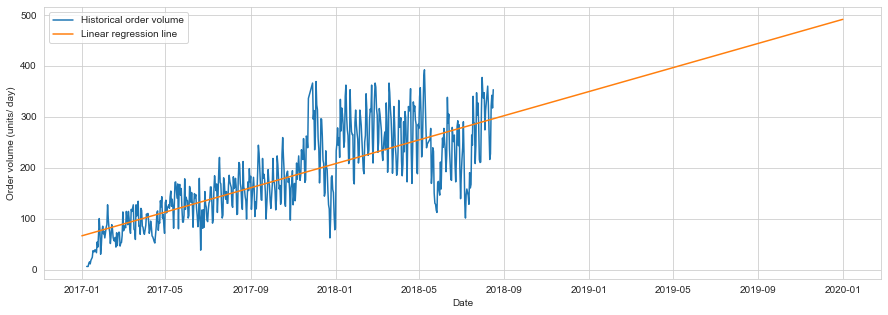

In [85]:
plt.figure(figsize = (15, 5))
sns.lineplot(
            data = df_orders_no_peaks,
            x = 'order_purchase_timestamp',
            y = 'qty'
            )
sns.lineplot(
            data = df_pred,
            x = 'date',
            y = 'reg_line'
            )
plt.xlabel('Date')
plt.ylabel('Order volume (units/ day)')
plt.legend(['Historical order volume', 'Linear regression line']);

To satisfy a system sizing, a point in the higher capacity range needs to be selected. Let's take a look at the distribution:

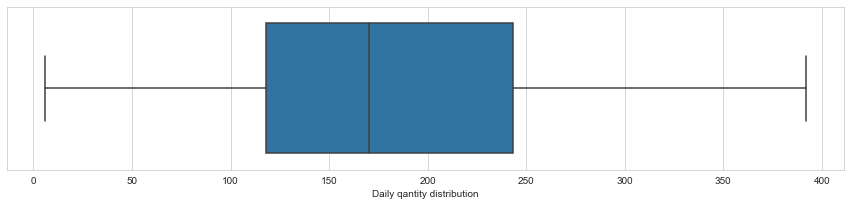

In [86]:
plt.figure(figsize = (15,3))
sns.boxplot(y = 'qty', data = df_orders_no_peaks, orient='h')
plt.xlabel('Daily qantity distribution');

The third quartile seems to be a good initial level.

In [87]:
design_to_avergae_factor = np.percentile(df_orders_no_peaks['qty'], 75)\
                            /np.median(df_orders_no_peaks['qty'])

In [88]:
# Creating design capacity line
df_pred['design_value'] = df_pred['reg_line'] * design_to_avergae_factor

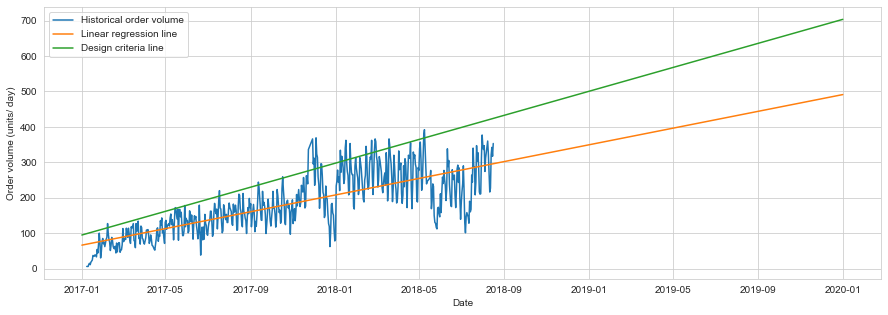

In [89]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df_orders_no_peaks, x='order_purchase_timestamp',y='qty')
sns.lineplot(data=df_pred, x='date',y='reg_line')
sns.lineplot(data=df_pred, x='date',y='design_value')
plt.xlabel('Date')
plt.ylabel('Order volume (units/ day)')
plt.legend([
        'Historical order volume',
        'Linear regression line',
        'Design criteria line'
        ]);

## Conclusion:
The order volume is too dynamic to do a very safe prognosis. The linear regression model with data outliers removed reaches a prediction probability of 55-65%. Sizing an automated logistic system for this profile is very challenging. Sizing a system to the observed peak would be very costly, sizing it to a lower level would require to find solutions at times with over-capacity. It would come down to a balancing act of comparing degrees of automation and added manpower in heavy periods.

We are looking at average 500 units per day in 2020. This is a very low number for an automated system. It's likely that there would be no good ROI.

Exporting generated dataframes

In [91]:
#df_order_items_consolidated.to_csv('df_orders_consolidated.csv')